(C) 2025 Gerold Baier, University College London

# Two Nonlinear Two-Population Oscillators with Perturbation
## Model

The two populations' temporal dynamics (change of state) is described by two first-order nonlinear differential equations. Here we have two coupled units:

$$ \frac{dEx_1}{dt}      = (h_{ex}      - Ex_1    - c_2*sigmoid(In_1) + c_{EE}*sigmoid((Ex_1 + 
frac_E*Ex_2))  + pert)*\tau_{ex}$$
$$ \frac{dIn_1}{dt} \,\, = (h_{in} \,\, - In_1 \, - c_4*sigmoid(In_1) + c_{EI}*sigmoid((Ex_1 + 
frac_I*Ex_2)))*\tau_{in}$$

$$ \frac{dEx_2}{dt}      = (h_{ex}      - Ex_2    - c_2*sigmoid(In_2) + c_{EE}*sigmoid((Ex_2 + 
frac_E*Ex_1)))*\tau_{ex}$$
$$ \frac{dIn_2}{dt} \,\, = (h_{in} \,\, - In_2 \, - c_4*sigmoid(In_2) + c_{EI}*sigmoid((Ex_2 + 
frac_I*Ex_1)))*\tau_{in}$$

$Ex_i$ and $In_i$ are variables that change with time $t$ and represent the excitatory and inhibitory population, respectively.

$h_{ex}$ and $h_{in}$ are constant inputs to the populations. 

$c_2$ and $c_4$ are model parameters representing internal inhibitory coupling. 

$\tau_{ex}$ and $\tau_{in}$ are the poulation time constants.

$c_{EE}$ and $c_{EI}$ are self- and between population excitatory coupling parameters.

_pert_ represents external perturbation.

Function _sigmoid_ is a continuous step function, conmputationally implemented as tangens hyperbolicus.


In [2]:
from scipy.integrate import odeint

from numpy import tanh, mod, linspace, around, zeros, mod, asarray
from numpy import sin, pi, var, ndarray, flip, arange, sign

from numpy.random import default_rng, seed

from matplotlib.pyplot import subplots

import sk_dsp_comm.sigsys as ss

from scipy.signal import find_peaks

from itertools import product


# Functions

In [3]:
def sigmoid(u):
    return tanh(u)

def oscillator(y, t, N, h_ex, h_in, pars, frac_E, frac_I, sr, time_stop, pert):
               
    tau_ex, tau_in, c2, c4, c_EE, c_EI = pars

    if len(pert) == 0:

        dydt = (

        
            (h_ex - y[0] - c2*sigmoid(y[1]) + c_EE*sigmoid(y[0]+frac_E*y[2]))*tau_ex,
             
            (h_in - y[1] - c4*sigmoid(y[1]) + c_EI*sigmoid(y[0]+frac_I*y[2]))*tau_in,

             
            (h_ex - y[2] - c2*sigmoid(y[3]) + c_EE*sigmoid(y[2]+frac_E*y[0]))*tau_ex,
            
            (h_in - y[3] - c4*sigmoid(y[3]) + c_EI*sigmoid(y[2]+frac_I*y[0]))*tau_in
           )
        
        return dydt


    else:

        time_index = int(t*sr)

        if time_index >= time_stop*sr:

            dydt = zeros(2*N)

            return dydt


        else:
            
            dydt = (

                (pert[time_index] - y[0] - c2*sigmoid(y[1]) + c_EE*sigmoid(y[0]+frac_E*y[2]))*tau_ex,
                 
                (h_in             - y[1] - c4*sigmoid(y[1]) + c_EI*sigmoid(y[0]+frac_I*y[2]))*tau_in,

                 
                (h_ex             - y[2] - c2*sigmoid(y[3]) + c_EE*sigmoid(y[2]+frac_E*y[0]))*tau_ex,
                
                (h_in             - y[3] - c4*sigmoid(y[3]) + c_EI*sigmoid(y[2]+frac_I*y[0]))*tau_in
               )

            return dydt


def plot_bifdiagram_scan(results, freq_set):

    if freq_set[-1] < freq_set[0]:
        
        freq_set = flip(freq_set)

    freq_min, freq_max = freq_set[0], freq_set[-1]

    fig, ax  = subplots(nrows=1, figsize=(5, 4))

    for result in results:
    
        results_min_f, results_max_f = result[0], result[1] 
      
        for xe, ye in zip(freq_set, results_max_f[0]):
    
            if not isinstance(ye, ndarray):
                ax.scatter(xe, ye, c='k', s=5)
            else:
                ax.scatter([xe] * len(ye), ye, c='r', s=5, marker='o')
    
        for xe, ye in zip(freq_set, results_min_f[0]):
    
            if not isinstance(ye, ndarray):
                ax.scatter(xe, ye, c='k', s=5)
            else:
                ax.scatter([xe] * len(ye), ye, c='b', s=5, marker='x')
    
        ax.set_xticks(linspace(freq_min, freq_max, 5));
        ax.set_xticklabels([]);
    
        ax.set_ylabel('Ex', fontsize=14)
    
        y_min, y_max = ax.get_ylim()

        # y_min, y_max = 0.5, 1.5

        ax.set_ylim(y_min, y_max)
        ax.set_yticks(linspace(y_min, y_max, 3))
        ax.set_yticklabels(around(linspace(y_min, y_max, 3)), fontsize=12)

    ax.set_xticks(linspace(freq_min, freq_max, 5));
    ax.set_xticklabels(around(linspace(freq_min, freq_max, 5), 2), fontsize=12);
    
    ax.set_xlabel('Parameter', fontsize=16)

    fig.tight_layout()
    
    return fig, ax


def plot_bifdiagram(results_min_f, results_max_f, 
                    par_set):
    
    N = len(results_min_f)

    fig, ax = subplots(figsize=(6, 4))

    for xe, ye in zip(par_set, results_max_f[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=6, marker='D')
        else:
            ax.scatter([xe] * len(ye), ye, s=3, c='k', marker='D')

    for xe, ye in zip(par_set, results_min_f[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=6, marker='d')
        else:
            ax.scatter([xe] * len(ye), ye, s=3, c='gray', marker='d')


    ax.set_xticks(linspace(par_set[0], par_set[-1], 5));
    ax.set_xticklabels(around(linspace(par_set[0], par_set[-1], 5), 2), fontsize=16);
    ax.set_xlabel('Parameter', fontsize=16)

    ax.set_ylabel('EX', fontsize=14)

    y_min, y_max = ax.get_ylim()

    ax.set_yticks(linspace(y_min, y_max, 3));
    ax.set_yticklabels(around(linspace(y_min, y_max, 3),2), fontsize=14);

    fig.tight_layout()
    
    return fig, ax

# Time Series

In [ ]:
h_ex_0 = -6.95, h_in_0 = -4.0, frac_E, frac_I = 0.2, 0.00 
h_ex_0 = -7.0,  h_in_0 = -4.0, frac_E, frac_I = 0.2, 0.12 

End of run: [ -1.83 -13.5   -1.83 -13.5 ]



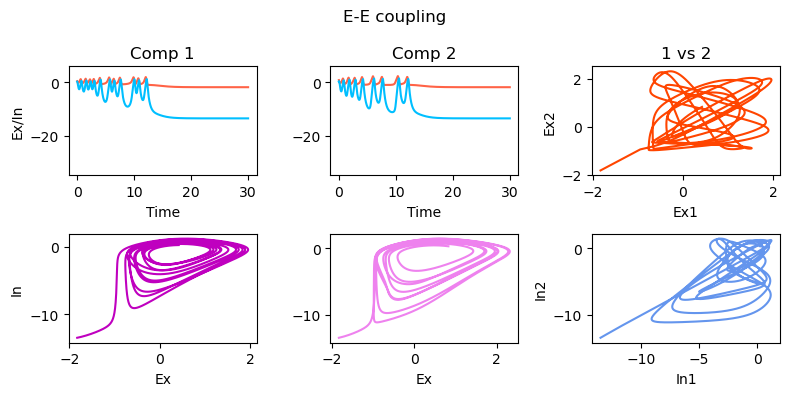

In [11]:
N = 2

# Input parameter
h_ex_0 = -6.95
h_in_0 = -4.0

# Oscillator parameters
pars = (1, 2.5, 10, 0, 5, 10) # Homoclinic
# pars = (1, 1.5, 10, 0, 5, 10) # SNIC
# t_ex, t_in, c2, c4, cc_EE, cc_EI

# Strong synchronisation
# frac_E, frac_I = 0.5, 0.0 # < 0, 0 means no coupling

# Temporary desynchronisation
# frac_E, frac_I = 0.0, 0.5 # 0, 0 means no coupling

frac_E, frac_I = 0.2, 0. # < 0, 0 means no coupling

# Initial conditions
SEED = 12249
rng  = default_rng(SEED)
y_ini = rng.uniform(size=2*N)

# Time array
time_stop = 30
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

pulse = []

# Simulation
y = odeint(func=oscillator, y0=y_ini, t=time, 
          args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop, pulse), 
          hmax=0.1)

# Resetting of initial conditions
y_ini = y[-1, :]

# Show final values of all variables
print('End of run:', around(y[-1,:],2))
print('')


fig, ax = subplots(ncols=3, nrows=2, figsize=(8, 4))

ax[0, 0].plot(time, y[:,0], color='tomato');
ax[0, 0].plot(time, y[:,1], color='deepskyblue');
ax[0, 1].plot(time, y[:,2], color='tomato');
ax[0, 1].plot(time, y[:,3], color='deepskyblue');

ax[1, 0].plot(y[:, 0], y[:, 1], color='m');
ax[1, 1].plot(y[:,2], y[:,3], color='violet');

ax[0, 2].plot(y[:,0], y[:,2], color='orangered');
ax[1, 2].plot(y[:,1], y[:,3], color='cornflowerblue');

ax[0, 0].set_xlabel('Time')
ax[0, 1].set_xlabel('Time')
ax[0, 0].set_ylabel('Ex/In')
ax[1, 0].set_xlabel('Ex')
ax[1, 0].set_ylabel('In')
ax[1, 1].set_xlabel('Ex')
ax[0, 2].set_xlabel('Ex1')
ax[0, 2].set_ylabel('Ex2')
ax[1, 2].set_xlabel('In1')
ax[1, 2].set_ylabel('In2')

ax[0, 0].set_title('Comp 1')
ax[0, 1].set_title('Comp 2')
ax[0, 2].set_title('1 vs 2')

y_min, y_max = y.min(), y.max()
ax[0, 0].set_ylim(y_min*(1-0.1*(y_max-y_min)*sign(y_min)), y_max*(1+0.1*(y_max-y_min)*sign(y_max)))
ax[0, 1].set_ylim(y_min*(1-0.1*(y_max-y_min)*sign(y_min)), y_max*(1+0.1*(y_max-y_min)*sign(y_max)))


if frac_E > 0 and frac_I == 0:
    
    chars = 'E-E coupling'
    fig.suptitle(chars)

elif frac_E == 0 and frac_I > 0:
    
    chars = 'E-I coupling'
    fig.suptitle(chars)

elif frac_E > 0 and frac_I > 0:
    
    chars = 'E-E & E-I coupling'
    fig.suptitle(chars)

else:
    
    chars = 'No coupling'
    fig.suptitle(chars)
    
fig.tight_layout()


End of run: [ -1.9  -13.72  -1.9  -13.72]



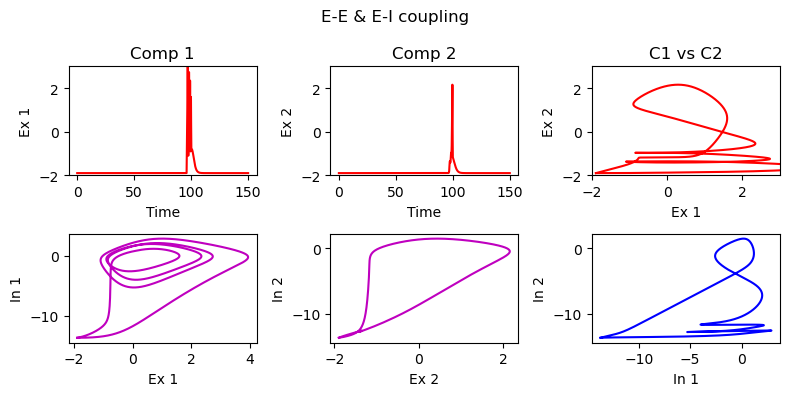

In [91]:
# h_ex_0 = -7.06
# frac_E, frac_I = 0.5, 0.0 # < 1. 0 means no coupling

pulse_wid = 4.
pulse_amp = 4.
pulse_per = 200

# Initial conditions
SEED = 12345
rng  = default_rng(SEED)
# y_in = rng.uniform(size=2*N)

# Time array
time_stop = 150
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

rows = time.size

pert = h_ex_0 + pulse_amp*ss.rect(mod(time, pulse_per)-(pulse_per)/2+pulse_wid/2, pulse_wid)


# Simulation
y_pert = odeint(func=oscillator, y0=y_ini, t=time, 
              args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop, pert), 
              hmax=0.1)

y_medium = y_pert.copy()

# Resetting of initial conditions
# y_in = y_pert[-1, :]

# Show final values of all variables
print('End of run:', around(y_pert[-1,:],2))
print('')

fig, ax = subplots(ncols=3, nrows=2, figsize=(8, 4))

ax[0, 0].plot(time, y_pert[:,0], color='r');
ax[0, 1].plot(time, y_pert[:,2], color='r');

ax[1, 0].plot(y_pert[:,0], y_pert[:,1], color='m');
ax[1, 1].plot(y_pert[:,2], y_pert[:,3], color='m');

ax[0, 2].plot(y_pert[:,0], y_pert[:,2], color='r');
ax[1, 2].plot(y_pert[:,1], y_pert[:,3], color='b');


ax[0, 0].set_title('Comp 1')
ax[0, 1].set_title('Comp 2')
ax[0, 2].set_title('C1 vs C2')

ax[0, 0].set_xlabel('Time')
ax[0, 0].set_ylabel('Ex 1')
ax[1, 0].set_xlabel('Ex 1')
ax[1, 0].set_ylabel('In 1')
ax[0, 1].set_xlabel('Time')
ax[0, 1].set_ylabel('Ex 2')
ax[1, 1].set_xlabel('Ex 2')
ax[1, 1].set_ylabel('In 2')

ax[0, 2].set_xlabel('Ex 1')
ax[0, 2].set_ylabel('Ex 2')
ax[1, 2].set_xlabel('In 1')
ax[1, 2].set_ylabel('In 2')


ax[0, 0].set_ylim(-2, 3)
ax[0, 1].set_ylim(-2, 3)
ax[0, 2].set_xlim(-2, 3)
ax[0, 2].set_ylim(-2, 3)



if frac_E > 0 and frac_I == 0:
    
    chars = 'E-E coupling'
    fig.suptitle(chars)

elif frac_E == 0 and frac_I > 0:
    
    chars = 'E-I coupling'
    fig.suptitle(chars)

elif frac_E > 0 and frac_I > 0:
    
    chars = 'E-E & E-I coupling'
    fig.suptitle(chars)

else:
    
    chars = 'No coupling'
    fig.suptitle(chars)
    
fig.tight_layout()

# Test Pulse

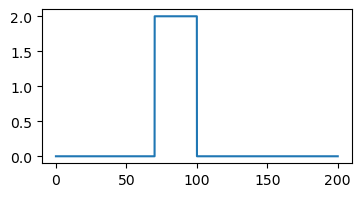

In [85]:
pulse_period    = 200
pulse_width     = 30
pulse_amplitude = 2

# pulse_width, pulse_amplitude = best_stim_params[pert_osc][0], best_stim_params[pert_osc][1]

time_stop_s  = 200
time_res     = 1000
time_steps_s = time_stop_s*time_res
time_s       = linspace(start=0, stop=time_stop_s, num=time_steps_s)

pulse = pulse_amplitude*ss.rect(mod(time_s, pulse_period)-pulse_period/2+pulse_width/2, pulse_width)

fig, ax = subplots(figsize=(4, 2))

ax.plot(time_s, pulse);

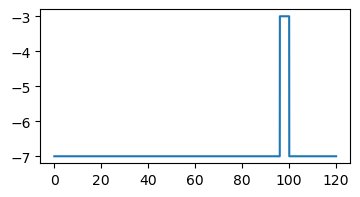

In [92]:
fig, ax = subplots(figsize=(4, 2))

ax.plot(time[:120000], pert[:120000]);

# Distance Metrics

In [128]:
import numpy as np
from scipy.spatial.distance import euclidean

def path_length(trajectory):
    """Calculate the total path length of a trajectory"""
    displacements = np.linalg.norm(np.diff(trajectory, axis=0), axis=1)
    return np.sum(displacements)

def trajectory_difference_path_based(trajectory_data):
    """
    Compare trajectories based on their actual path characteristics
    """
    osc1_traj = trajectory_data[:, :2]
    osc2_traj = trajectory_data[:, 2:]
    
    # 1. Path length difference
    path1_length = path_length(osc1_traj)
    path2_length = path_length(osc2_traj)
    path_length_diff = abs(path1_length - path2_length)
    
    # 2. Area between paths (integrated distance)
    distances = np.linalg.norm(osc1_traj - osc2_traj, axis=1)
    area_between = np.trapz(distances, dx=1)
    
    # 3. Dynamic differences (velocity/orientation)
    vel1 = np.diff(osc1_traj, axis=0)
    vel2 = np.diff(osc2_traj, axis=0)
    
    # Cosine similarity of velocities (how aligned are movements)
    dot_products = np.sum(vel1 * vel2, axis=1)
    norms_product = np.linalg.norm(vel1, axis=1) * np.linalg.norm(vel2, axis=1)
    cosine_similarities = dot_products / (norms_product + 1e-10)  # avoid division by zero
    avg_alignment = np.mean(cosine_similarities)
    
    return {
        'path_length_difference': path_length_diff,
        'area_between_paths': area_between,
        'velocity_alignment': avg_alignment,
        'composite_measure': path_length_diff + area_between + (1 - avg_alignment)
    }

def dtw_distance(a, b):
    """Simple DTW implementation"""
    n, m = len(a), len(b)
    dtw_matrix = np.zeros((n+1, m+1))
    dtw_matrix[0, 1:] = np.inf
    dtw_matrix[1:, 0] = np.inf
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],    # insertion
                                         dtw_matrix[i, j-1],    # deletion  
                                         dtw_matrix[i-1, j-1])  # match
    
    return dtw_matrix[n, m]

def trajectory_difference_dtw(trajectory_data):
    """
    Use DTW to handle trajectories that are similar but phase-shifted
    """
    osc1_traj = trajectory_data[:, :2]
    osc2_traj = trajectory_data[:, 2:]
    
    # Apply DTW to each dimension separately
    dtw_x = dtw_distance(osc1_traj[:, 0], osc2_traj[:, 0])
    dtw_y = dtw_distance(osc1_traj[:, 1], osc2_traj[:, 1])
    
    # Combined DTW distance
    combined_dtw = np.sqrt(dtw_x**2 + dtw_y**2)
    
    return combined_dtw

def trajectory_shape_difference(trajectory_data):
    """
    Compare the shape characteristics of trajectories
    """
    osc1_traj = trajectory_data[:, :2]
    osc2_traj = trajectory_data[:, 2:]
    
    # Calculate curvature for each trajectory
    def calculate_curvature(traj):
        dx_dt = np.gradient(traj[:, 0])
        dy_dt = np.gradient(traj[:, 1])
        d2x_dt2 = np.gradient(dx_dt)
        d2y_dt2 = np.gradient(dy_dt)
        
        curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2 + 1e-10)**1.5
        return curvature
    
    curvature1 = calculate_curvature(osc1_traj)
    curvature2 = calculate_curvature(osc2_traj)
    
    # Compare curvature profiles
    curvature_diff = np.mean(np.abs(curvature1 - curvature2))
    
    # Compare turning points (local maxima in curvature)
    from scipy.signal import find_peaks
    peaks1, _ = find_peaks(curvature1, height=np.mean(curvature1))
    peaks2, _ = find_peaks(curvature2, height=np.mean(curvature2))
    
    turning_point_diff = abs(len(peaks1) - len(peaks2))
    
    return curvature_diff + turning_point_diff

def comprehensive_trajectory_analysis(trajectory_data):
    """
    Comprehensive analysis that should distinguish different path types
    """
    osc1_traj = trajectory_data[:, :2]
    osc2_traj = trajectory_data[:, 2:]
    
    results = {}
    
    # Basic point-wise distances (your original approach)
    point_distances = np.linalg.norm(osc1_traj - osc2_traj, axis=1)
    results['max_point_distance'] = np.max(point_distances)
    results['mean_point_distance'] = np.mean(point_distances)
    results['area_between'] = np.trapezoid(point_distances, dx=1)
    
    # Path-based measures
    results['path_length_osc1'] = path_length(osc1_traj)
    results['path_length_osc2'] = path_length(osc2_traj)
    results['path_length_difference'] = abs(results['path_length_osc1'] - results['path_length_osc2'])
    
    # Dynamic measures
    vel1 = np.diff(osc1_traj, axis=0)
    vel2 = np.diff(osc2_traj, axis=0)
    
    velocity_correlations = []
    for i in range(len(vel1)):
        if np.linalg.norm(vel1[i]) > 0 and np.linalg.norm(vel2[i]) > 0:
            cos_sim = np.dot(vel1[i], vel2[i]) / (np.linalg.norm(vel1[i]) * np.linalg.norm(vel2[i]))
            velocity_correlations.append(cos_sim)
    
    results['velocity_correlation'] = np.mean(velocity_correlations) if velocity_correlations else 0
    
    # Shape-based measure
    results['shape_difference'] = trajectory_shape_difference(trajectory_data)
    
    # Create a single composite score
    results['composite_score'] = (
        results['area_between'] + 
        results['path_length_difference'] + 
        (1 - results['velocity_correlation']) +
        results['shape_difference']
    )
    
    return results


result_similar = comprehensive_trajectory_analysis(y_similar[105000:120000, :])

result_different = comprehensive_trajectory_analysis(y_different[105000:120000, :])

result_medium = comprehensive_trajectory_analysis(y_medium[105000:120000, :])

print("Similar trajectories:", result_similar['composite_score'])
print("Different trajectories:", result_different['composite_score'])
print("Medium trajectories:", result_medium['composite_score'])


Similar trajectories: 8624.300107775958
Different trajectories: 24771.765353695973
Medium trajectories: 54975.10050609993


In [118]:
result_similar

{'max_point_distance': np.float64(5.289331091709366),
 'mean_point_distance': np.float64(0.5749351955355837),
 'area_between': np.float64(8622.315682854667),
 'path_length_osc1': np.float64(36.908308037977434),
 'path_length_osc2': np.float64(35.12698331057021),
 'path_length_difference': np.float64(1.781324727407224),
 'velocity_correlation': np.float64(0.9730216308729599),
 'shape_difference': np.float64(0.17612182475539645),
 'composite_score': np.float64(8624.300107775958)}

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def extract_measures(trajectory_data):
    """
    Extract the three measures from a trajectory
    """
    # Reuse the functions from our previous analysis
    results = comprehensive_trajectory_analysis(trajectory_data)
    
    max_dist = results['max_point_distance']
    path_diff = results['path_length_difference']
    shape_diff = results['shape_difference']
    
    return [max_dist, path_diff, shape_diff]

# Alternative: Individual functions if you want them separate
def max_point_distance(trajectory_data):
    osc1_traj = trajectory_data[:, :2]
    osc2_traj = trajectory_data[:, 2:]
    distances = np.linalg.norm(osc1_traj - osc2_traj, axis=1)
    return np.max(distances)

def path_length_difference(trajectory_data):
    osc1_traj = trajectory_data[:, :2]
    osc2_traj = trajectory_data[:, 2:]
    
    def path_length(traj):
        displacements = np.linalg.norm(np.diff(traj, axis=0), axis=1)
        return np.sum(displacements)
    
    path1 = path_length(osc1_traj)
    path2 = path_length(osc2_traj)
    return abs(path1 - path2)

def shape_difference(trajectory_data):
    osc1_traj = trajectory_data[:, :2]
    osc2_traj = trajectory_data[:, 2:]
    
    def calculate_curvature(traj):
        dx_dt = np.gradient(traj[:, 0])
        dy_dt = np.gradient(traj[:, 1])
        d2x_dt2 = np.gradient(dx_dt)
        d2y_dt2 = np.gradient(dy_dt)
        
        curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2 + 1e-10)**1.5
        return curvature
    
    curvature1 = calculate_curvature(osc1_traj)
    curvature2 = calculate_curvature(osc2_traj)
    
    from scipy.signal import find_peaks
    peaks1, _ = find_peaks(curvature1, height=np.mean(curvature1))
    peaks2, _ = find_peaks(curvature2, height=np.mean(curvature2))
    
    curvature_diff = np.mean(np.abs(curvature1 - curvature2))
    turning_point_diff = abs(len(peaks1) - len(peaks2))
    
    return curvature_diff + turning_point_diff

def plot_3d_trajectory_clusters(trajectories, labels=None, colors=None):
    """
    Create a 3D scatter plot of trajectory measures
    
    Parameters:
    trajectories: list of numpy arrays, each shape (samples, 4)
    labels: optional list of labels for each trajectory
    colors: optional list of colors for each trajectory
    """
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # If no colors provided, use a colormap
    if colors is None:
        colors = plt.cm.tab10(np.linspace(0, 1, len(trajectories)))
    elif len(colors) != len(trajectories):
        colors = [colors[0]] * len(trajectories)  # Use first color for all
    
    # Collect all measures for axis limits
    all_measures = []
    
    for index, trajectory in enumerate(trajectories):
        # Calculate the three measures
        measures = [
            max_point_distance(trajectory),
            path_length_difference(trajectory), 
            shape_difference(trajectory)
        ]
        
        all_measures.append(measures)
        
        # Create label
        if labels is not None and index < len(labels):
            label = labels[index]
        else:
            label = f'Traj {index+1}'
        
        # Plot the point
        ax.scatter(*measures, 
                  c=[colors[index]], 
                  s=100, 
                  label=label,
                  alpha=0.7,
                  edgecolors='w',
                  linewidth=0.5)
    
    all_measures = np.array(all_measures)
    
    # Set labels and title
    ax.set_xlabel('Max Point Distance', fontsize=12, labelpad=10)
    ax.set_ylabel('Path Length Difference', fontsize=12, labelpad=10)
    ax.set_zlabel('Shape Difference', fontsize=12, labelpad=10)
    ax.set_title('3D Trajectory Clustering', fontsize=14, fontweight='bold', pad=20)
    
    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust viewing angle for better visualization
    ax.view_init(elev=20, azim=45)
    
    plt.tight_layout()
    plt.show()
    
    return all_measures

# Enhanced version with clustering visualization
def plot_3d_trajectory_clusters_enhanced(trajectories, group_labels=None, cluster_colors=None):
    """
    Enhanced version with better grouping and visualization
    """
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define colors for different groups
    if cluster_colors is None:
        cluster_colors = plt.cm.Set1(np.linspace(0, 1, len(set(group_labels)) if group_labels else 1))
    
    all_measures = []
    
    for index, trajectory in enumerate(trajectories):
        measures = [
            max_point_distance(trajectory),
            path_length_difference(trajectory), 
            shape_difference(trajectory)
        ]
        all_measures.append(measures)
        
        # Determine color and label based on grouping
        if group_labels and index < len(group_labels):
            group_idx = group_labels[index]
            color = cluster_colors[group_idx]
            label = f'Group {group_idx}' if index == 0 or group_labels[index-1] != group_idx else ""
        else:
            color = 'blue'
            label = f'Traj {index+1}'
        
        ax.scatter(*measures, 
                  c=[color], 
                  s=100, 
                  label=label,
                  alpha=0.7,
                  edgecolors='w',
                  linewidth=1)
    
    all_measures = np.array(all_measures)
    
    # Set labels with units if known
    ax.set_xlabel('Max Distance\n(larger = more separation)', fontsize=11, labelpad=10)
    ax.set_ylabel('Path Length Diff\n(larger = different path lengths)', fontsize=11, labelpad=10)
    ax.set_zlabel('Shape Difference\n(larger = different shapes)', fontsize=11, labelpad=10)
    ax.set_title('3D Trajectory Measure Space\n(Cluster Analysis)', fontsize=14, fontweight='bold', pad=20)
    
    # Add grid and improve layout
    ax.grid(True, alpha=0.3)
    
    # Remove duplicate labels in legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), 
              bbox_to_anchor=(1.15, 1), loc='upper left')
    
    # Multiple viewing angles
    print("Plotting from multiple angles...")
    angles = [(30, 45), (20, 135), (10, 225)]
    
    for i, (elev, azim) in enumerate(angles):
        ax.view_init(elev=elev, azim=azim)
        plt.draw()
        plt.pause(0.5)  # Brief pause to see different angles
    
    plt.tight_layout()
    plt.show()
    
    return all_measures

# Simple version following your pseudocode exactly
def simple_3d_plot(trajectory):
    """
    Simple version following your pseudocode exactly
    """
 
    for index, trajectory in enumerate(trajectories):
        measures = [
            max_point_distance(trajectory),
            path_length_difference(trajectory), 
            max_point_distance(trajectory)
        ]
        
        ax.scatter(*measures, s=80, alpha=0.7, label=f'Traj {index+1}')
    
    ax.set_xlabel('Max Point Distance')
    ax.set_ylabel('Path Length Difference')
    ax.set_zlabel('Shape Difference')
    ax.set_title('3D Trajectory Measures')
    ax.legend()
    
    plt.show()


# 3D Scatter of trajectories measures

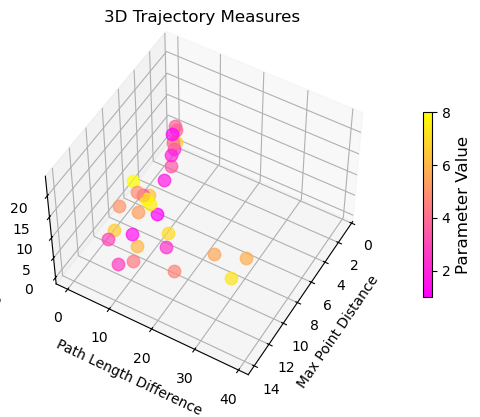

In [41]:
pulse_wid = 4.
pulse_per = 200.

# Time array
time_stop = 200
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

rows = time.size

fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(projection='3d')

pulse_amps = linspace(1, 8, 30)


measures_all = list()

for pulse_amp in pulse_amps:
    
    pert = h_ex_0 + pulse_amp*ss.rect(mod(time, pulse_per)-(pulse_per)/2+pulse_wid/2, pulse_wid)

    # Simulation
    y_pert = odeint(func=oscillator, y0=y_ini, t=time, 
                  args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop, pert), 
                  hmax=0.1)

    trajectory = y_pert[105000:130000, :]
    
    measures = [max_point_distance(trajectory), path_length_difference(trajectory), shape_difference(trajectory)]

    measures_all.append(measures)


param_min, param_max = np.min(pulse_amps), np.max(pulse_amps)
param_norm = (pulse_amps - param_min) / (param_max - param_min)

colormap = plt.get_cmap('spring')

for ind, meas in enumerate(measures_all):
    
    color = colormap(param_norm[ind])

    scatter = ax.scatter(*meas, s=80, alpha=0.7, color=color)

# Create colorbar with the correct colormap
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=colormap, 
                                        norm=plt.Normalize(param_min, param_max)), 
                   ax=ax, shrink=0.4, aspect=20, pad=0.1)
cbar.set_label('Pulse Amplitude')


ax.set_xlabel('Max Point Distance')
ax.set_ylabel('Path Length Difference')
ax.set_zlabel('Shape Difference')
ax.set_title('3D Trajectory Measures')


ax.view_init(50, 30)


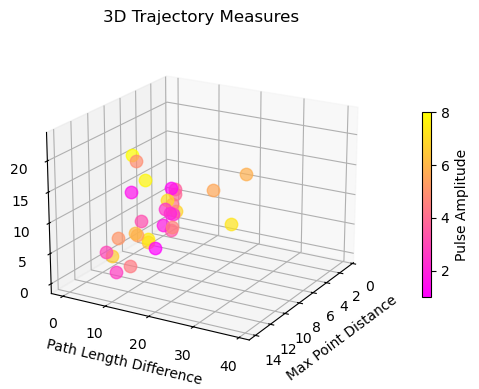

In [43]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(projection='3d')

for ind, meas in enumerate(measures_all):
    
    color = colormap(param_norm[ind])

    scatter = ax.scatter(*meas, s=80, alpha=0.7, color=color)

# Create colorbar with the correct colormap
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=colormap, 
                                        norm=plt.Normalize(param_min, param_max)), 
                   ax=ax, shrink=0.4, aspect=20, pad=0.1)
cbar.set_label('Pulse Amplitude')


ax.set_xlabel('Max Point Distance')
ax.set_ylabel('Path Length Difference')
ax.set_zlabel('Shape Difference')
ax.set_title('3D Trajectory Measures')

ax.view_init(20, 30)

# Using itertools product

Good but should store the maximum and minimum of oscillator 2: y[:,2:].max(), y[:,2:].min() and then filter plotting: if max_2 - min_2 > threshold: plot point. This avoids plotting cases where oscillator 2 does not fire but only passively follows osc 1.

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

def create_2d_colormap():
    """Create a colormap that interpolates between four corners"""
    colors = [
        [1, 0, 0],  # Red - bottom-left
        [0, 1, 0],  # Green - bottom-right
        [0, 0, 1],  # Blue - top-left  
        [1, 1, 0],  # Yellow - top-right
    ]
    return LinearSegmentedColormap.from_list('four_corners', colors, N=256)



pulse_per = 200.

# Time array
time_stop = 200
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

rows = time.size


pulse_amps = linspace(2, 5, 40)
pulse_wids = linspace(2, 5, 40)


measures_all    = list()
combined_params = list()  # Store combined parameter values for coloring
color_values    = list()
osc_2_amps      = list()

for pulse_wid, pulse_amp in product(pulse_wids, pulse_amps):

    pert = h_ex_0 + pulse_amp*ss.rect(mod(time, pulse_per)-(pulse_per)/2+pulse_wid/2, pulse_wid)

    # Simulation
    y_pert = odeint(func=oscillator, y0=y_ini, t=time, 
                  args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop, pert), 
                  hmax=0.1)

    trajectory = y_pert[100000:130000, :]

    osc_2_extr = trajectory[:, 2].max() - trajectory[:, 2].min()
    osc_2_amps.append(osc_2_extr)
    
    measures = [max_point_distance(trajectory), path_length_difference(trajectory), shape_difference(trajectory)]

    measures_all.   append(measures)
    combined_params.append(pulse_wid * pulse_amp) 

    # Create a combined value that captures both dimensions
    wid_norm = (pulse_wid - pulse_wids.min()) / (pulse_wids.max() - pulse_wids.min())
    amp_norm = (pulse_amp - pulse_amps.min()) / (pulse_amps.max() - pulse_amps.min())
    
    # This formula gives a smooth gradient across the 2D space
    combined_value = (wid_norm + amp_norm) / 2  # or try other combinations
    color_values.append(combined_value)


measures_array = np.array(measures_all)
# combined_params = np.array(combined_params)
color_values   = np.array(color_values)

mask = asarray(osc_2_amps) > 1

#################
# Plot
fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(111, projection='3d')

custom_cmap = create_2d_colormap()

scatter = ax.scatter(measures_array[mask, 0], measures_array[mask, 1], measures_array[mask, 2],
                    c=color_values[mask], cmap=custom_cmap, s=40, alpha=0.7)

cbar = plt.colorbar(scatter, ax=ax, shrink=0.4)
cbar.set_label('Combined Parameter Value')

ax.set_xlabel('Max Distance')
ax.set_ylabel('Path Difference') 
ax.set_zlabel('Shape Difference')
ax.set_title('3 feature space for two-parameter scan - Four Corner Colors');


In [138]:
len(color_values)

1600

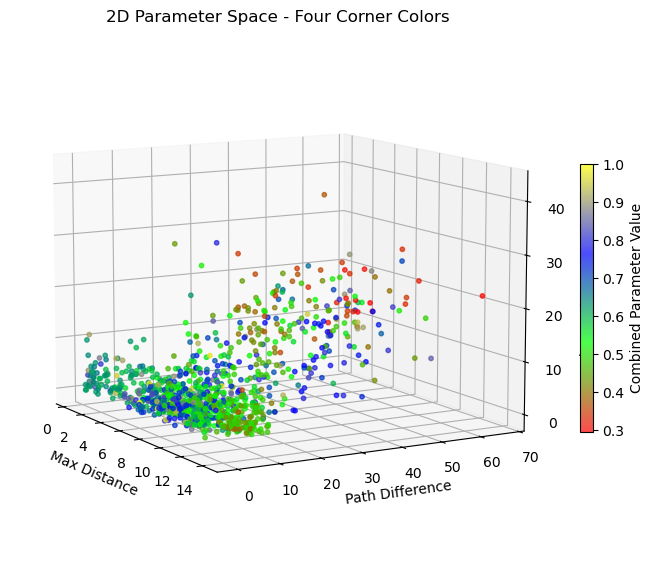

In [139]:
fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(111, projection='3d')

custom_cmap = create_2d_colormap()

mask = asarray(osc_2_amps) > 2

scatter = ax.scatter(measures_array[mask, 0], measures_array[mask, 1], measures_array[mask, 2],
                        c=asarray(color_values)[mask], cmap=custom_cmap, s=10, alpha=0.7)

cbar = plt.colorbar(scatter, ax=ax, shrink=0.4)
cbar.set_label('Combined Parameter Value')


ax.set_xlabel('Max Distance')
ax.set_ylabel('Path Difference') 
ax.set_zlabel('Shape Difference')
ax.set_title('2D Parameter Space - Four Corner Colors')

ax.view_init(10, -30)

fig.tight_layout()


# Plotly Version

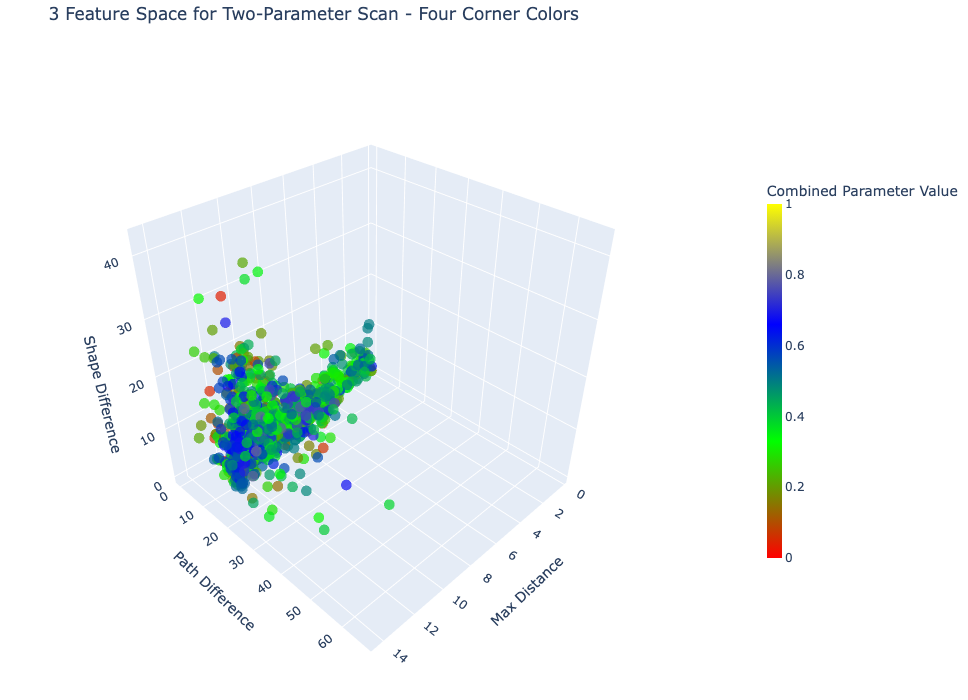

In [140]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

# Convert your matplotlib colormap to Plotly
def create_plotly_colorscale(cmap_name='spring', n_colors=256):
    """Convert matplotlib colormap to Plotly colorscale"""
    cmap = plt.get_cmap(cmap_name)
    colorscale = []
    for i in range(n_colors):
        ratio = i / (n_colors - 1)
        rgb = cmap(ratio)
        colorscale.append([ratio, f'rgb({rgb[0]*255:.0f}, {rgb[1]*255:.0f}, {rgb[2]*255:.0f})'])
    return colorscale

# Create custom four-corner colorscale for Plotly
def create_four_corner_colorscale():
    """Create the same four-corner colorscale in Plotly"""
    return [
        [0.0, 'rgb(255, 0, 0)'],    # Red
        [0.33, 'rgb(0, 255, 0)'],   # Green
        [0.66, 'rgb(0, 0, 255)'],   # Blue
        [1.0, 'rgb(255, 255, 0)']   # Yellow
    ]

# Create the interactive Plotly figure
fig = go.Figure(data=[go.Scatter3d(
    x=measures_array[mask, 0],      # Max Distance
    y=measures_array[mask, 1],      # Path Difference
    z=measures_array[mask, 2],      # Shape Difference
    mode='markers',
    marker=dict(
        size=6,
        color=color_values,      # Combined Parameter Value
        colorscale=create_four_corner_colorscale(),  # Your custom colormap
        opacity=0.7,
        colorbar=dict(
            title='Combined Parameter Value',
            thickness=15,
            len=0.6
        )
    ),
    hovertemplate=(
        "<b>Max Distance:</b> %{x:.3f}<br>" +
        "<b>Path Difference:</b> %{y:.3f}<br>" +
        "<b>Shape Difference:</b> %{z:.3f}<br>" +
        "<b>Param Value:</b> %{marker.color:.3f}<br>" +
        "<extra></extra>"
    )
)])

# Update layout for better appearance
fig.update_layout(
    title='3 Feature Space for Two-Parameter Scan - Four Corner Colors',
    scene=dict(
        xaxis_title='Max Distance',
        yaxis_title='Path Difference',
        zaxis_title='Shape Difference',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)  # Initial camera position
        )
    ),
    width=700,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

# Pulse Parameter Scan 2D

COMPLETE
 


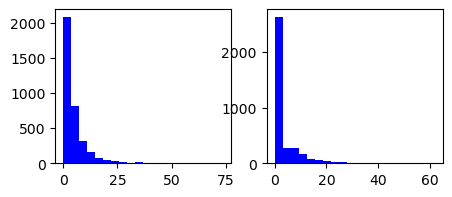

In [67]:
# Initial conditions y_last
y_last = y_ini.copy()

time_stop_pert = 200
sr             = 1000
time           = linspace(start=0, stop=time_stop_pert, num=time_stop_pert*sr)

resolution = 60

pulse_width_min, pulse_width_max = 0.1, 5.1
pulse_ampli_min, pulse_ampli_max = 5, 0.0001

pulse_width = linspace(pulse_width_min, pulse_width_max, resolution)
pulse_ampli = linspace(pulse_ampli_min, pulse_ampli_max, resolution)

pulse_period = 200

results_pert = list()

for pulse_wid, pulse_amp in product(pulse_width, pulse_ampli):

    h_ex_p = h_ex_0 + pulse_amp*ss.rect(mod(time, pulse_period)-pulse_period/2+pulse_wid/2, pulse_wid)

    y = odeint(func=oscillator, y0=y_last, t=time, args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop_pert, h_ex_p),
              hmax=0.1)


    results_pert.append((sum(y[time_stop_pert*sr//2:, 0] - y_last[0])/sr, 
                         sum(y[time_stop_pert*sr//2:, 2] - y_last[2])/sr
                     ))

results_pert_ex1_matrix = asarray(results_pert)[:, 0].reshape(resolution, resolution)
results_pert_ex2_matrix = asarray(results_pert)[:, 1].reshape(resolution, resolution)

print('COMPLETE')
print(' ')

fig, ax = subplots(ncols=2, figsize=(5, 2))

ax[0].hist(results_pert_ex1_matrix.ravel(), bins=20, color='b');

ax[1].hist(results_pert_ex2_matrix.ravel(), bins=20, color='b');

fig.tight_layout()


'PulsePert_Homoclinic_frac_E=0.2_frac_I=0.12.png'

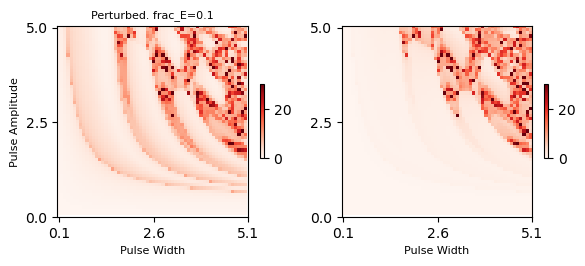

In [68]:
vmin1, vmax1 = 0, 30
vmin2, vmax2 = 0, 30

fig, ax = subplots(figsize=(6, 4), ncols=2)

im1 = ax[0].imshow(results_pert_ex1_matrix.T, cmap='Reds', vmin=vmin1, vmax=vmax1)

ax[0].set_xlabel('Pulse Width', fontsize=8)
ax[0].set_ylabel('Pulse Amplitude', fontsize=8)
ax[0].set_xticks(linspace(0, resolution, 3))
ax[0].set_xticklabels(around(linspace(pulse_width_min, pulse_width_max, 3),1))
ax[0].set_yticks(linspace(0, resolution, 3))
ax[0].set_yticklabels(around(linspace(pulse_ampli_min, pulse_ampli_max, 3), 2))
ax[0].set_title('Perturbed. frac_E=0.1', fontsize=8)



im2 = ax[1].imshow(results_pert_ex2_matrix.T, cmap='Reds', vmin=vmin2, vmax=vmax2)

ax[1].set_xlabel('Pulse Width', fontsize=8)
# ax[1].set_ylabel('Pulse Amplitude', fontsize=8)
ax[1].set_xticks(linspace(0, resolution, 3))
ax[1].set_xticklabels(around(linspace(pulse_width_min, pulse_width_max, 3), 1))
ax[1].set_yticks(linspace(0, resolution, 3))
ax[1].set_yticklabels(around(linspace(pulse_ampli_min, pulse_ampli_max, 3), 2))


fig.colorbar(im1, ax=ax[0], shrink=0.2);
fig.colorbar(im2, ax=ax[1], shrink=0.2);

fig.tight_layout()

if pars[1] == 1.5:
    
    title_chars = 'Figs/N=1/Fig_2Cb_PulsePert_SNIC.png'
    
elif pars[1] == 2.5:

    title_chars = 'PulsePert_Homoclinic_frac_E=' + str(frac_E) + '_frac_I=' + str(frac_I) +'.png'

# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')

title_chars